# Training with Augmented data

## Regression, determining inclinations

In this notebook, we train a VGG model using the augmented data. Data augmentation has been done separately in another code and the output data has been stored on disk for the purpose of the following analysis.

128x128 images are used for this analysis, which are in grayscale (g,r,i filter) or colorful (RGB). All images are presented in 3 channels. For grayscale images, all three channels are the same.

Inclinations range from 45 to 90 degrees.

### These are some of the features of the training sample

Half of the grayscale images have black background, i.e. galaxy and stars are in white color.
In half of the grayscale cases, objects are in black on white background.
Half of the sample is in grayscale, and the other half is in grayscale.
The augmentation process has been forced to generate images that cover the entire inclinations uniformly.


## Challenges

When we switched to higher resolution images, and added augmentation of top of that, the size of required memory to open up the entire augmented sample is out of the capability of the available machines. Thus, we resolved the problem by saving the training sample in 50 separate batches all already randomized in any way. Each step of the training process starts with loading the corresponding batch, reconstructing the CNN as it was generated in the previous iteration, and advancing the training process for on more step. At the end of that repetition, we store a snapshot of the network weights for the next training step.

### Pros:
- We can generate as many training galaxies as required without being worry about the memory size
- We can stop the training process at any point and continue the process from where it is left. This helps is the process crashes due to the lack of enough memory that happens if other irrelevant processes clutter the system
- We are able to constantly monitor the training process and make decisions as it goes on


### Cons:
- This process is slow. The bottle neck is the i/o process, not training and updating the weight numbers of the network.


### Notes:
- Since we are dealing with a large training sample, we need to repeat updating the network weights for many steps to cover all training batches several times
- Over-fitting sometimes helps to minimize the prediction-measurement bias 

## Importing packages

In [1]:
import sys, os, gc
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import random
from datetime import datetime
import json
import imgaug as ia
import imgaug.augmenters as iaa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical

## Defining the VGG model

Here, we work with the simplest model in the serie of our analysis. 
VGG model benefits from convolutional layers with convolutional filters of size 3x3.

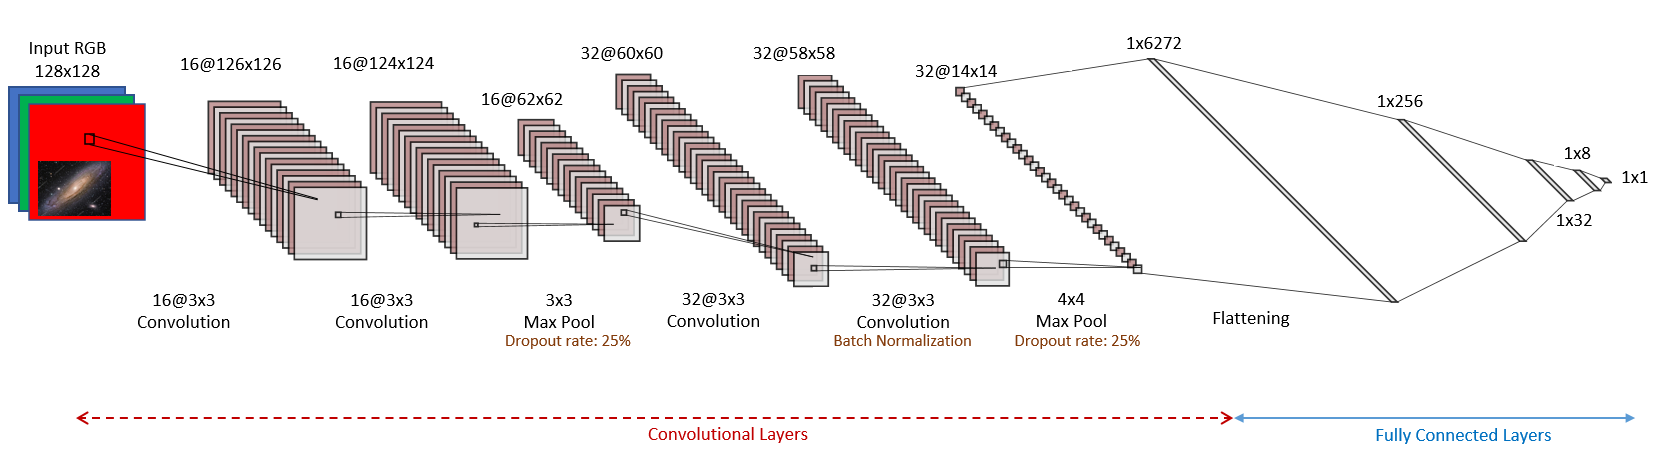

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename = "./model4_network.png")

In [3]:
def vgg(input_shape=(128, 128, 3)):


    model = tf.keras.models.Sequential(name='VGG')

    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn_2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    ## Fully connected layers
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_2'))
    model.add(tf.keras.layers.Dense(32, activation='relu', name='fc_4'))
    model.add(tf.keras.layers.Dense(8, activation='relu', name='fc_5'))
    
    # output layer
    model.add(tf.keras.layers.Dense(1, activation='tanh', name='fc_out2'))

    return model

def esn_shuffle(array, seed=0):
        np.random.seed(seed)
        np.random.shuffle(array)
        return array

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)


In [4]:
model = vgg()
model.summary()

Model: "VGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 126, 126, 16)      448       
_________________________________________________________________
conv2 (Conv2D)               (None, 124, 124, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 62, 16)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 60, 60, 32)        4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 58, 58, 32)        9248      
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 58, 58, 32)        128     

### A customized shuffling function to randomize the input arrays

In [5]:
def esn_shuffle(array, seed=None):
        if seed is not None:
            np.random.seed(seed)
        np.random.shuffle(array)
        return array

### Augmentations for the test images

In [6]:
seq = iaa.Sequential([
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.1))),
    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 3), per_channel=0.5),
    iaa.Add((-5, 5), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.5),
    iaa.Sometimes(0.1, iaa.Grayscale(alpha=(0.0, 1.0))),
    iaa.Sometimes(0.50, iaa.Grayscale(alpha=1.)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(0, 255))
    ], random_order=True)


seqGray = iaa.Sequential([
    iaa.GammaContrast(gamma=(0.97,1.03)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Affine(
        rotate=(0, 359),
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}, 
        mode=ia.ALL, cval=(255, 255))
    ], random_order=True)

### Importing text images

`samples/<filter>_128x128_test_000.npz` have not been already augmented. Therefore we augment them in the same way we prepared the training sample.

In [7]:
%%time 

data = np.load('samples/RGB_128x128_test_000.npz')
images_RGB = data['images'].astype(np.uint8)
labels_RGB = data['labels'] 
pgcIDs_RGB = data['pgcIDs']
N = images_RGB.shape[0]
filter_RGB = np.chararray(N)
filter_RGB[:] = 'c'
data.close() 
del data


data = np.load('samples/g_128x128_test_000.npz')
images_g = data['images'].astype(np.uint8)
labels_g = data['labels'] 
pgcIDs_g = data['pgcIDs']
N = images_g.shape[0]
filter_g = np.chararray(N)
filter_g[:] = 'g'
data.close() 
del data

data = np.load('samples/r_128x128_test_000.npz')
images_r = data['images'].astype(np.uint8)
labels_r = data['labels'] 
pgcIDs_r = data['pgcIDs']
N = images_r.shape[0]
filter_r = np.chararray(N)
filter_r[:] = 'r'
data.close() 
del data

data = np.load('samples/i_128x128_test_000.npz')
images_i = data['images'].astype(np.uint8)
labels_i = data['labels'] 
pgcIDs_i = data['pgcIDs']
N = images_i.shape[0]
filter_i = np.chararray(N)
filter_i[:] = 'i'
data.close() 
del data

CPU times: user 2.17 s, sys: 64.4 ms, total: 2.24 s
Wall time: 2.24 s


### Concatenating the gray test images taken at g, r, and i bands

In [8]:
images_gri = np.concatenate((images_g, images_r, images_i))
labels_gri = np.concatenate((labels_g, labels_r, labels_i))
pgcIDs_gri = np.concatenate((pgcIDs_g, pgcIDs_r, pgcIDs_i))
filter_gri = np.concatenate((filter_g, filter_r, filter_i))

N_RGB = len(labels_RGB)
N_gri = len(labels_gri)

Here, we shuffle `gri` images and then we randomly invert half of them. In this way half of the galaxy images have black background and the other half have white background.

In [9]:
ia.seed(100)

indx = esn_shuffle(np.arange(N_gri), seed=200)
images_aug = seqGray(images=images_gri[indx][:N_RGB,:,:,:])
labels_aug = labels_gri[indx][:N_RGB]
pgcIDs_aug = pgcIDs_gri[indx][:N_RGB]
filter_aug = filter_gri[indx][:N_RGB]

n = len(images_aug)
p = int(n/2)
images_aug[:p] = 255 - images_aug[:p]

ia.seed(200)

images_aug = np.concatenate((seq(images=images_RGB),images_aug))
labels_aug = np.concatenate((labels_RGB,labels_aug))
pgcIDs_aug = np.concatenate((pgcIDs_RGB,pgcIDs_aug))
filter_aug = np.concatenate((filter_RGB,filter_aug))

indx = np.arange(len(images_aug))
indx = esn_shuffle(indx, seed=100)
images_test_aug = images_aug[indx]
labels_test_aug = labels_aug[indx]
pgcIDs_test_aug = pgcIDs_aug[indx]
filter_test_aug = filter_aug[indx]

# inclinations are mapped to range between -1 and 1, compatibale with the tanh outputs
labels_test_aug = 2.*(labels_test_aug-45.)/45. - 1.

### Batch number generation

We have 50 batches of training data, each stored in a separate `npz` file on the disk.
Each grand Epoch includes all 50 random iterations that cover the entire training sample. Within each epoch, batches are fed to the network in different orders.
Below, we generate 60 grand epochs of 50 small iterations. Each iteration covers one training sub-sample in `npz` format.

In [10]:
batches = esn_shuffle(np.arange(50), seed=20)

for i in range(1,60):
    batches = np.concatenate((batches, esn_shuffle(np.arange(50), seed=i*20))) 

batches, len(batches)

(array([12, 14,  4, ..., 14, 15, 45]), 3000)

## Training Process

- *zp_dir:* Folder that contains all 50 training batches in `npz` format
- *ckpt_dir:* Folder to save the weight numbers of the network after each iteration


Advancing the training process at each step consists of

1.  Reconstruction of the model as it is at the end of the previous step
2.  Reading the `npz` file that holds the corresponding batch
3.  Training the model for one epoch (moving forward just for 1 iteration)
4.  Updating the JSON file that contains the desired network metrics
5.  Saving the weight values of the model for the use in the next iteration


The input data directory name is formatted as `Uset<index>_npz`, where `U` stands for the sample with uniform distribution of inclinations. `<index>` is codes as following:
- `index = 0` if all training galaxies are taken to construct the network.
- `index = 1, 2, and 3` if `2/3` of the training galaxies (chosen randomly with replacement) are adopted to train the network. The `index` number is used to label all corresponding output directories that hold the network weight numbers and other relevant outputs.  

In [20]:
zp_dir = 'Uset0_npz/'
ckpt_dir = 'U0_model04_ckpt/'

def trainer(iter, batches, suffix=None):

  if suffix is None:
    suffix = ''

  batchNo = batches[iter]
  if True: 
    
    ## initializing the model in the beginning of each iteration
    vgg_model = vgg()
    vgg_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae'])

    if iter>0:
      
      vgg_model = vgg()
      vgg_model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(), metrics=['mse', 'mae'])
    
      ## if we are in  the middle of the training process, we load the weight number of the network 
      ## produced in the previous step
      vgg_model.load_weights(ckpt_dir+str(iter-1)+suffix+".ckpt")

      ## The networks performance metrics are stored in JSON and is updated at each step
      with open(ckpt_dir+'evalDict'+suffix+'.json') as json_file:
        evalDict = json.load(json_file)
    else:
      evalDict = {}


    print("iter #{}".format(iter))
    print("Batch number: {}".format(batchNo))

    
    # reading out the training batch from disk
    batchFile = npzname = '128x128_train_aug_'+'%02d'%(batchNo+1)+'.npz'
    data = np.load(zp_dir + batchFile)
    images_train_aug = data['images'].astype(np.uint8)
    labels_train_aug = data['labels']
    pgcIDs_train_aug = data['pgcIDs']
    data.close() 
    del data
    
    # mapping out the labels to lie between -1 and 1
    labels_train_aug = 2.*(labels_train_aug-45.)/45. - 1.
    
    n_epochs=1
    vgg_model.fit(images_train_aug, labels_train_aug, 
                                      epochs=n_epochs, batch_size=64, 
                                      validation_data=(images_test_aug, labels_test_aug),
                                      verbose=1, shuffle=True)
    
    # updating the JSON file that holds all metrics
    evalDict[iter] = {} 
    for key in vgg_model.history.history:
      evalDict[iter][key] = vgg_model.history.history[key][0]
    evalDict[iter]["batchNo"] = batchNo
    evalDict[iter]["batchFile"] = batchFile
    
    with open(ckpt_dir+"evalDict"+suffix+".json", "w", encoding ='utf8') as outfile:
      json.dump(evalDict, outfile, allow_nan=True, cls=NpEncoder)
    
    
    ## Taking an snapshot of the network to be used in the proceeding iteration
    vgg_model.save_weights(ckpt_dir+str(iter)+suffix+".ckpt")

    del vgg_model
    tf.keras.backend.clear_session()
    del images_train_aug 
    del labels_train_aug
    del pgcIDs_train_aug

    gc.collect()

    return evalDict

### Training the network for 2000-3000 iterations

or until achieving convergence.

If the training process doesn't improve the evaluations metrics on the test (evaluation) set, we stop the training process. 

In [ ]:
with tf.device('/gpu:0'):
    for i in range(0, 2000):
        trainer(i, batches)

iter #0
Batch number: 12
282/282 [==============================] - 11s 40ms/step - loss: 0.5406 - mse: 0.5406 - mae: 0.5624 - val_loss: 0.6122 - val_mse: 0.6122 - val_mae: 0.6748
iter #1
Batch number: 14
282/282 [==============================] - 6s 21ms/step - loss: 0.2114 - mse: 0.2114 - mae: 0.3632 - val_loss: 0.2937 - val_mse: 0.2937 - val_mae: 0.4558
iter #2
Batch number: 4
282/282 [==============================] - 6s 20ms/step - loss: 0.1662 - mse: 0.1662 - mae: 0.3212 - val_loss: 0.2899 - val_mse: 0.2899 - val_mae: 0.4455
iter #3
Batch number: 8
282/282 [==============================] - 6s 20ms/step - loss: 0.1565 - mse: 0.1565 - mae: 0.3089 - val_loss: 0.2205 - val_mse: 0.2205 - val_mae: 0.3866
iter #4
Batch number: 45
282/282 [==============================] - 6s 20ms/step - loss: 0.1446 - mse: 0.1446 - mae: 0.2973 - val_loss: 0.2290 - val_mse: 0.2290 - val_mae: 0.3974
iter #5
Batch number: 1


## Plotting the evaluation metrics

The following analysis is constantly performed to monitor the behavior of the network as it trains. 

In [16]:
import pandas as pd

with open(ckpt_dir+"evalDict.json") as json_file:
        evalDict = json.load(json_file)

df =  pd.DataFrame.from_dict(evalDict).T   

df.tail()

,loss,mse,mae,val_loss,val_mse,val_mae,batchNo,batchFile
1995,0.0196274,0.0196274,0.10533,0.0319133,0.0319133,0.125248,11,128x128_train_aug_12.npz
1996,0.0200213,0.0200213,0.10587,0.0289167,0.0289167,0.118677,46,128x128_train_aug_47.npz
1997,0.0205183,0.0205183,0.106837,0.0296556,0.0296556,0.119519,34,128x128_train_aug_35.npz
1998,0.0195099,0.0195099,0.104999,0.0301228,0.0301228,0.120843,25,128x128_train_aug_26.npz
1999,0.019815,0.019815,0.105056,0.0304177,0.0304177,0.120573,21,128x128_train_aug_22.npz


The training process can be stopped about the iteration #1000, however a little bit of over training helps to remove the prediction-measurement bias and reduce the size of fluctuations in the metrics.

(0.1, 0.3)

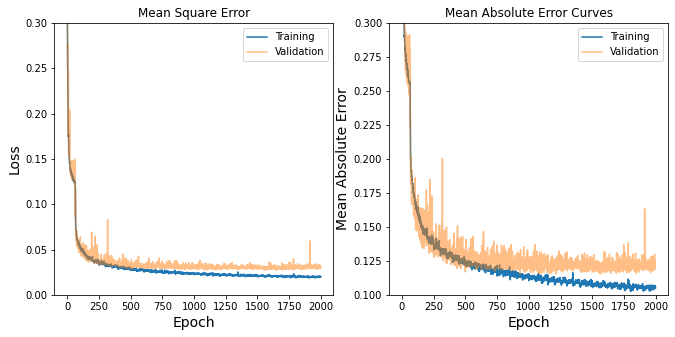

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,5))

epochs = np.arange(len(df))

ax[0].plot(epochs, df.mse.values, label='Training')
ax[0].plot(epochs, df.val_mse, label='Validation', alpha=0.5)
ax[0].set_title('Mean Square Error')
ax[0].legend()
ax[0].set_xlabel('Epoch', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].set_ylim(0, 0.3)

ax[1].plot(epochs, df.mae.values, label='Training')
ax[1].plot(epochs, df.val_mae, label='Validation', alpha=0.5)
ax[1].set_title('Mean Absolute Error Curves')
ax[1].legend()
ax[1].set_xlabel('Epoch', fontsize=14)
ax[1].set_ylabel('Mean Absolute Error', fontsize=14)
ax[1].set_ylim(0.1, 0.3)

## Predictions vs. Actual measurements

We cross compare the evaluated inclinations versus the actual labels.

To get better understanding of the model performance, we plot the difference between the evaluated inclinations and the measured values by users ($\Delta i-i_m-i_p$). In the following plot, the horizontal axis shows the measured inclinations. Each point represents a galaxy in the test sample.

- **Left Panel:** Predicted values $i_p$, are directly generated by applying the trained network on the test sample. Red sold line displays the results of a least square linear fit on the blue points. Evidently, there is a inclination dependent bias that is inclination dependent. This bias has been linearly modeled by the red line, which is utilized to adjust the predicted values. The slope and intercept of the fitted line are encoded in the $m$ and $b$ parameters.
- **Right Panel:** Same as the left panel, with adjusted predictions, $i_{pc}$, that is calculated using $i_{pc}= \frac{i_p+b}{1-m}$.

**Note:** The root mean square of the prediction$-$measurements differences is $~4^o$. The similar metric is $~2.6^o$ when we compare the measured values of two groups of the human users. This means our model is slightly performs worst than human, and most of that poor performances is attributed to the outliers and features (like data noise, point sources, stellar spikes, poor images, etc.) with no enough data coverage.

The performance of the trained network is slightly worse than our prototype ($~3^o$), because augmentation introduces a lot of different possibilities that requires a large sample and many more iterations to achieve the same goal. In the prototype model, we adopted 64x64 images, and all galaxies where aligned horizontally, whereas in the full augmented analysis, galaxies are left to have arbitrary position angles. This adds to the complexity of the problem.

Raw RMS:  4.065720043370877
Adjusted RMS:  4.102300686637453


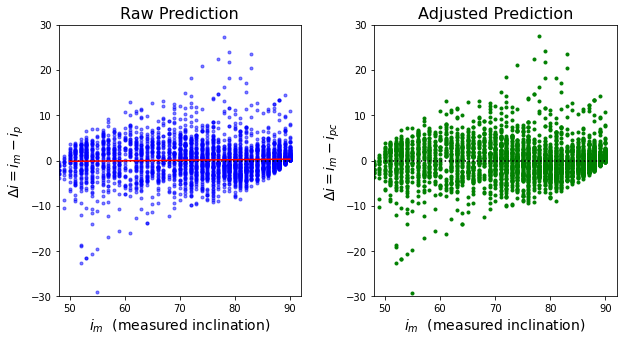

In [19]:
with tf.device('/gpu:0'):    
    vgg_model = vgg()
    vgg_model.load_weights(ckpt_dir+"1400.ckpt")

    inc_p = vgg_model.predict(images_test_aug)
    inc_m = 0.5*(labels_test_aug+1.)*45.+45.

    N = images_test_aug.shape[0]
    inc_p = inc_p.reshape(N)
    inc_p = 0.5*(inc_p+1.)*45.+45.


    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 
    
    
    d = inc_m-inc_p
    
    ix = ((d<12)&(d>-12))

    m, b = np.polyfit(inc_m[ix], d[ix], 1)
    x = np.linspace(50,90,20)
    y  = m*x+b

    ax[0].plot(inc_m, d, 'b.', alpha=0.5)
    ax[0].plot([50,90],[0,0], 'k:')
    ax[0].plot(x, y, 'r-')
    ax[0].set_xlim(48,92)
    ax[0].set_ylim(-30 ,30)
    ax[0].set_title('Raw Prediction', fontsize=16)
    ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
    ax[0].set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=14)

    print("Raw RMS: ", np.sqrt(np.mean((d)**2)))

    inc_p2 = (inc_p+b)/(1.-m)
#     inc_p2[(inc_p2>90)] = 90

    d_ = inc_m-inc_p2
    ax[1].plot(inc_m, d_, 'g.')
    ax[1].plot([50,90],[0,0], 'k:')
    ax[1].set_xlim(48,92)
    ax[1].set_ylim(-30,30)

    print("Adjusted RMS: ", np.sqrt(np.mean((d_)**2)))
    ax[1].set_title('Adjusted Prediction', fontsize=16)
    ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
    ax[1].set_ylabel(r'$\Delta i = i_m-i_{pc}$', fontsize=14)

    plt.subplots_adjust( wspace=0.3)

## Visualizing the outliers

Here, we show the first 49 galaxy images in the test sample, where the predicted value is far from the actual measurements, i.e. $\Delta i > 10^o$.

In each panel, cyan label is the galaxy ID in the Principal Galaxy Catalog (PGC), and green and red labels represent the measured and the predicted inclinations. Magenta labels denote the panel numbers.

Some cases are interesting:

1. In panel #42, the galaxy image has been masked out because of the bright center of the galaxy has saturated the image at the center.
2. Case #26 is a typical case, where the galaxy image has been projected next to a bright star.
3. Cases like #2, #14, #23, #29, #43 have poor quality images.
4. Case #37 has been ruined in the data reduction process, when the telescope data has been preprocessed.

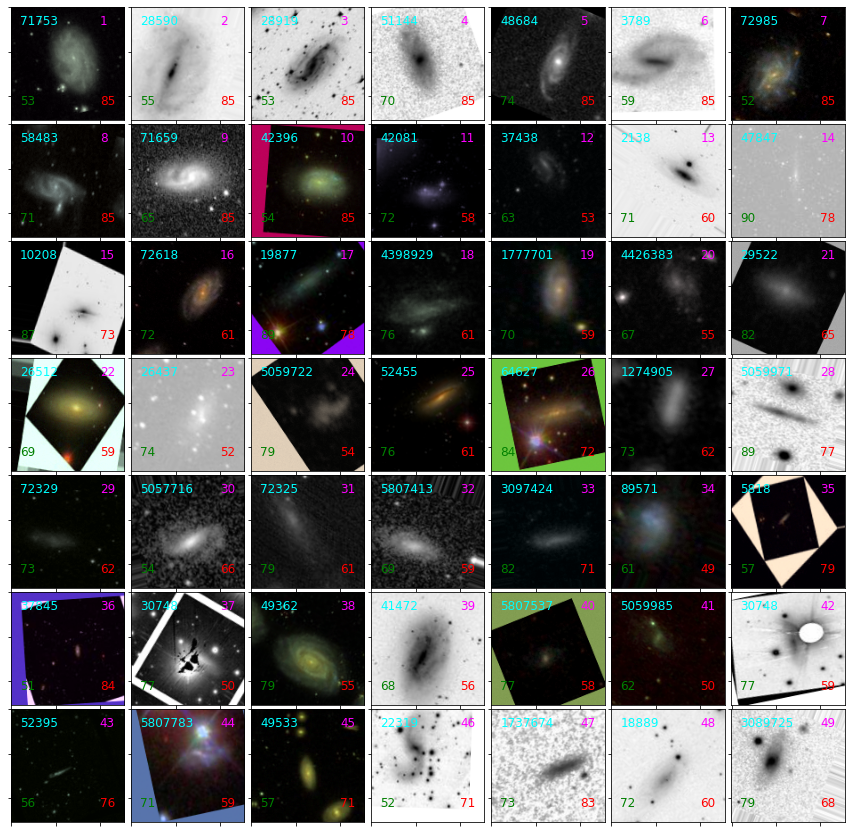

In [39]:
n = 7
m = 7

fig, axes = plt.subplots(nrows=n, ncols=m, figsize=(15,15)) 

t = 0 
ii = 1
delta = np.abs(inc_m[t]-inc_p[t])
for i in range(n):
    for j in range(m):
        
        while t<len(inc_m) and delta < 10:
          t += 1
          delta = np.abs(inc_m[t]-inc_p[t])
        ax = axes[i][j]
        ax.imshow(images_test_aug[t,:,:])

        plt.setp(ax.get_xticklabels(), visible=False)
        plt.setp(ax.get_yticklabels(), visible=False)

        ax.text(10, 110, "%.0f"%inc_m[t], color='green', fontsize=12)
        ax.text(100, 20, ii, color='magenta', fontsize=12); ii+=1
        ax.text(100, 110, "%.0f"%inc_p[t], color='red', fontsize=12)
        ax.text(10, 20, pgcIDs_test_aug[t], color='cyan', fontsize=12)

        t+=1
        delta = np.abs(inc_m[t]-inc_p[t])

plt.subplots_adjust(hspace=0.03, wspace=0.03)